# **Analyse de sentiments sur les films du TOP 100 box office (Notebook pour le processing des données) 2/3**
**Projet Python - 2A ENSAE**

AUMONT Louis-Armand, KHAIRALDIN Ahmed, GIMENES Vincent

## Introduction

L'objectif de ce Notebook va être de charger la base de données, puis nettoyer les commentaires pour les "tokenisés" et enfin les "lemmatisés"
et appliquer des algorithmes de NLP sur nos commentaires "lemmatisés" afin de déduire pour chaque commentaire un score de polarité et afin former un nouveau dataset final où chaque observation sera un film.

Avant de pouvoir faire de l'analyse de sentiment pour chaque commentaire, il faut d'abord les nettoyer pour les rendre lisibles pour l'ordinateur. Premièrement, nous allons transformer le fichier data_reviews en une base de données où chaque observation est un commentaire. Puis, nous allons nettoyer chaque commentaire en utilisant des fonctions permettant de supprimer la ponctuation, les stop-words et la lemmatisation.



####  Download Library ⚙️

In [1]:
#!pip install spacy
#!pip install wordcloud
#!pip install textblob

Il faut également télécharger une fois ces sortes de sous packages:

In [ ]:
# Téléchargement d'éléments nécessaires à la tokenisation
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Download the VADER lexicon for sentiment analysis
nltk.download('vader_lexicon')

In [ ]:
!python3 -m spacy download en_core_web_sm

####  Import Library 📦

In [2]:
# Importation de packages nécessaires

import pandas as pd
import json
import nltk
import spacy
import matplotlib.pyplot as plt


from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer

## **1.** Création de la base de données des commentaires, tokenisation et lemmatisation

### **1.1** Création du DataFrame

Nous allons ouvrir le dataset de telle façon qu'une observation est un commentaire sur un film

In [4]:
# Transformation du fichier json en un Dataframe Pandas

# Charger le fichier JSON
with open("data_reviews.json", 'r') as file:
    data = json.load(file)

In [5]:
movie_name = []
comments = []
notes = []
year= []
budget=[]
recette=[]
duree=[]

for movie, dico in data.items():
    if '0' in dico and isinstance(dico['0'], list):  # Vérifier si la clé '0' est une liste
        for comment in dico['0']:
            movie_name.append(movie)
            comments.append(comment)
            year.append(dico['1'])
            notes.append(dico['2'])
            budget.append(dico['3'])
            recette.append(dico['4'])
            duree.append(dico['5'])

df = pd.DataFrame({
    'Film': movie_name,
    'Commentaire': comments,
    'Annee':year,
    'Note imdb': notes,
    'Budget':budget,
    'Box office':recette,
    'duree':duree
})

df.sample(5)

,Film,Commentaire,Annee,Note imdb,Budget,Box office,duree
8539,Star Wars: Épisode I - La menace fantôme (1999),"Well, after waiting 16 years for his next inst...",1999,"6,5",115000000,1027082707,2h 16m
5061,Captain America: Civil War (2016),I like the what the makers of the Marvel movie...,2016,"7,8",250000000,1155046416,2h 27m
5951,Transformers 3 : La Face cachée de la Lune (2011),"""Dark Of The Moon"" is the first Transformers m...",2011,"6,2",195000000,1123794079,2h 34m
1755,Avengers (2012),This is the best superhero movie I have ever s...,2012,"8,0",220000000,1520538536,2h 23m
11677,Le Seigneur des anneaux : Les Deux Tours (2002),Literary no words. Perfection. Bravo to the ca...,2002,"8,8",94000000,948893109,2h 59m


### **1.2** Nettoyage des commentaires

#### **1.2.1** Tokenisation et suppression de la ponctuation

Il faut executer la cellule ci-dessous pour pouvoir charger le modèle de la langue anglaise de scapy.

In [6]:
# permet d'afficher un commentaire même si il est très long
pd.set_option('display.max_colwidth', None)

In [7]:
#oOn retire les "\n" dans les commentaires
df["Commentaire"] = df["Commentaire"].str.replace('\n','')
df["Commentaire"].sample()

8461    If we look back just a few years ago, Pixar really still was the company that seemed to be able to do no wrong but in these last few years for whatever reason the Pixar brand has taken a little bit of a hit.Sure there's still the great original films like Inside Out but there's also been miscued films like Brave, Monster's University, the tiresome Good Dinosaur and now the long talked about and hyped Finding Dory.2003's Finding Nemo is a film fondly remembered by many, I know I for one still very much remember witnessing the film for the first time at the cinema and enjoy every minute of it, but taking a character that was fine as a support to the films leads and turning them into the figurehead of this return to the sea really brings down the chances Finding Dory had of being much more than a pretty animated adventure that leaves nothing of a lasting impression.The forgetful fish Dory, once more voiced here by comedian Ellen DeGeneres, on a journey to find her parents that she

In [8]:
pd.set_option('display.max_colwidth', 100)

In [12]:
# On commence par charger le modèle de la langue anglaise de Spacy (les commentaires sont en anglais)
nlp = spacy.load('en_core_web_sm')

# Fonction qui prend en argument un commentaire (chaîne de caractère) et qui retourne une liste des tokens sans les stopwords et la ponctuation
def tokenize(text):
    doc = nlp(text)
    tokens = [token.text for token in doc if not token.is_stop and not token.is_punct]
    return tokens

In [13]:
%%time
# On crée une nouvelle colonne avec la liste des tokens pour chaque commentaire
df['Tokens'] = df['Commentaire'].apply(tokenize)
df.sample(5)

CPU times: user 11min 22s, sys: 3.43 s, total: 11min 25s
Wall time: 11min 25s


,Film,Commentaire,Annee,Note imdb,Budget,Box office,duree,Tokens
4808,Le Seigneur des anneaux : Le Retour du roi (2003),"Just as Peter Jackson felt that LOTR had to be made as one large, three-part, cinematic piece, I...",2003,"9,0",94000000,1155870721,3h 21m,"[Peter, Jackson, felt, LOTR, large, cinematic, piece, decided, write, IMDb, review, movies, sing..."
9551,The Dark Knight : Le Chevalier noir (2008),"In short, The Dark Knight is everything any Batfan could have dreamed of. It is the best of 2008...",2008,"9,0",185000000,1029266147,2h 32m,"[short, Dark, Knight, Batfan, dreamed, best, 2008, best, comic, book, film, time, greatest, acti..."
6214,Jurassic Park (1993),"Jurassic Park is, without a doubt, one of my favorite movies of all time. If I made a list of my...",1993,"8,2",63000000,1113138548,2h 7m,"[Jurassic, Park, doubt, favorite, movies, time, list, favorite, movies, Jurassic, Park, amazing,..."
1196,Spider-Man: No Way Home (2021),"""Spider-Man: No Way Home"" is an entertaining film for fans of the spider and Marvel, highlightin...",2021,"8,2",200000000,1921847111,2h 28m,"[Spider, Man, Way, Home, entertaining, film, fans, spider, Marvel, highlighting, script, multive..."
4245,Fast & Furious 8 (2017),"This was painful. Action? Yes, but we're talking Physics that Sharknado would be ashamed of. Fai...",2017,"6,6",250000000,1236005118,2h 16m,"[painful, Action, Yes, talking, Physics, Sharknado, ashamed, Failure, understand, accept, realit..."


Avec Spacy, l'algortihme s'exécute en près de  min pour l'ensemble de la base de données. Nous avons utilisé Spacy et non nltk pour la tokenization et la suppression des stopwords, puisque Spacy a un répertoire plus important de stopwords et a de meilleures performances pour les textes volumineux. Il est à noter que la fonction de tokenisation ne supprime pas les négations, donc l'analyse de sentiment ne sera pas biaisée.

#### **1.2.2** Lemmatisation des commentaires   
Nous allons désormais procéder à la lemmatisation des commentaires pour pouvoir allèger les algorithmes de NLP plus tard.

In [14]:
# Fonction qui prend en argument une liste de tokens et qui retourne ces tokens lemmatisés
def lemm(tokens):
    # D'abord, on transforme la liste en doc Spacy
    tokens_as_doc = spacy.tokens.Doc(nlp.vocab, words=tokens)
    # Lemmatisation du doc 
    lemmatized = [token.lemma_ for token in tokens_as_doc]
    return lemmatized
# Le lemma_ de Spacy ne reconnait pas les tokens et renvoie des listes vides (Pourquoi ?)

lemmatizer = WordNetLemmatizer()

def lemm2(tokens):
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized



In [15]:
# On crée une nouvelle colonne des tokens lemmatisés
df['Tokens lemmatisés'] = df['Tokens'].apply(lemm2)
df.sample(5)

,Film,Commentaire,Annee,Note imdb,Budget,Box office,duree,Tokens,Tokens lemmatisés
3170,Harry Potter et les Reliques de la Mort : partie 2 (2011),Thus endeth one of the most popular - and profitable - series in movie history. And the good new...,2011,"8,1",125000000,1356841356,2h 10m,"[endeth, popular, profitable, series, movie, history, good, news, ends, bang, whimper, push, clu...","[endeth, popular, profitable, series, movie, history, good, news, end, bang, whimper, push, clut..."
593,Titanic (1997),I've never watched Titanic until now. It caught my interest when I heard the story about those 5...,1997,"7,9",200000000,2264743305,3h 14m,"[watched, Titanic, caught, interest, heard, story, 5, people, lost, lives, expedition, Titanic, ...","[watched, Titanic, caught, interest, heard, story, 5, people, lost, life, expedition, Titanic, I..."
15393,Vice-versa (2015),"I was expecting a funny lighthearted animated movie, one I have come to expect from Pixar. Unfor...",2015,"8,1",175000000,858848019,1h 35m,"[expecting, funny, lighthearted, animated, movie, come, expect, Pixar, Unfortunately, funny, sce...","[expecting, funny, lighthearted, animated, movie, come, expect, Pixar, Unfortunately, funny, sce..."
8142,"Moi, moche et méchant 3 (2017)","I tend to be pretty easy to please with these movies but, believe it or not, the Minions carry ""...",2017,"6,2",80000000,1034800131,1h 29m,"[tend, pretty, easy, movies, believe, Minions, carry, Despicable, 3, Steve, Carell, pulling, dou...","[tend, pretty, easy, movie, believe, Minions, carry, Despicable, 3, Steve, Carell, pulling, doub..."
9620,Jurassic World: Le monde d'après (2022),Jurassic World Dominion is the third and final film in the Jurassic Park/World franchise. And wh...,2022,"5,6",165000000,1001978080,2h 27m,"[Jurassic, World, Dominion, final, film, Jurassic, Park, World, franchise, great, visuals, fun, ...","[Jurassic, World, Dominion, final, film, Jurassic, Park, World, franchise, great, visuals, fun, ..."


### **1.3** Représentation des mots

Maintenant, visualisons pour certains commentaires les mots les plus représentés après nettoyage des commentaires.

Commençons d'abord par visualiser un premier nuage de mots d'un commentaire quelconque.

In [16]:
# Fonction qui prend en argument une liste de tokens et qui retourne le nuage de mots correspondant.

def cloud(tokens):
    text = " ".join(tokens)
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    return wordcloud

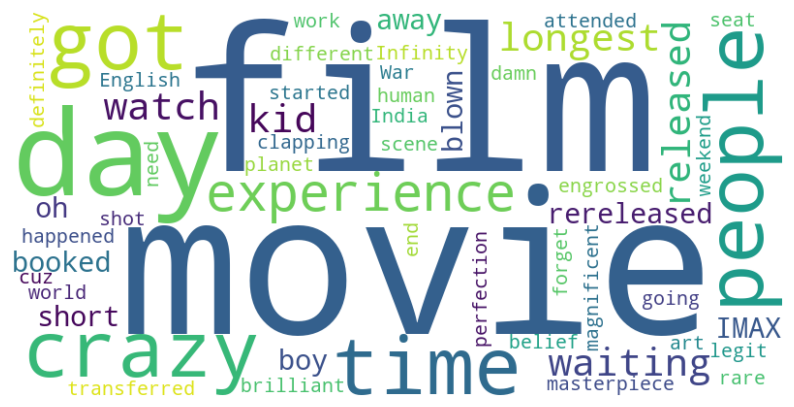

In [96]:
plt.figure(figsize=(10, 8))
plt.imshow(cloud(df['Tokens lemmatisés'][0]), interpolation='bilinear')
plt.axis("off")
plt.show()

Par exemple, pour le premier commentaire de la bdd, on peut dès à présent avoir une idée sur son avis vis à vis du film grâce à ce nuage de mots, de par la présence de mots tels que 'masterpiece, 'magnificent', 'perfection'... qui sont assez représentés. Néanmoins, comme nous avons utilisé nltk, le lemmatiseur ne reconnait pas les entités nommés telles que 'IMAX', 'India'... . 
La présence des mots concernants le temps comme "waiting", "time", "longest" nous indique que la durée du film est un sujet des commentaires et nous pourrons voir par la suite s'il existe une corrélation entre la durée du film et la polarité des commentaires.

## **2.** NLP et analyse des sentiments

Dans un premier temps nous allons appliquer les algorithmes de NLP sur les commentaires afin d'obtenir un score pour chaque commentaires puis nous allons modifier le dataset de telle sorte qu'une observation est un film.

### **2.1** application d'algorithmes d'analyses de sentiments

In [18]:
#Convertir les commentaires en string.
def string_function(column):
    return column.str.lower()

df['Commentaire'] =  string_function(df["Commentaire"])

Nous allons comparer les différents algorithmes proposés, notamment ceux des modules TextBlob, nltk.

On va dans un premier temps utiliser le module TextBlob

In [19]:
def analyze_sentiment_blob(tokens):
    text = ' '.join(tokens)
    blob = TextBlob(text)
    return blob.sentiment.polarity

In [20]:
# Appliquez la fonction à la colonne 'tokens_lemmatized' du DataFrame
df['sentiment_polarity_blob'] = df['Tokens lemmatisés'].apply(analyze_sentiment_blob)

On essaye maintenant avec la fonction SentimentIntensityAnalyzer de nltk

In [21]:
def analyze_sentiment_nltk(tokens):
    text = ' '.join(tokens)
    sia = SentimentIntensityAnalyzer()
    return sia.polarity_scores(text)['compound']

In [22]:
%%time
df['sentiment_polarity_nltk'] = df["Tokens lemmatisés"].apply(analyze_sentiment_nltk)

CPU times: user 1min 41s, sys: 660 ms, total: 1min 42s
Wall time: 1min 42s


La cellule ci-dessus prend environ 2 min à s'exécuter

### **2.2** manipulation pour la création du nouveau dataset

Les variables sont sous forme de string. Nous changeons cela pour pourvoir faire des statistiques avec.

In [23]:
df.dtypes

Film                        object
Commentaire                 object
Annee                       object
Note imdb                   object
Budget                      object
Box office                  object
duree                       object
Tokens                      object
Tokens lemmatisés           object
sentiment_polarity_blob    float64
sentiment_polarity_nltk    float64
dtype: object

In [24]:
#change le type de la colonne 'Note imdb' en float
df['Note imdb'] = df['Note imdb'].str.replace(',', '.').astype(float)
df['Annee'] = df['Annee'].astype(float)
df["Budget"] = df["Budget"].astype(float)
df['Box office'] = df["Box office"].astype(float)

On groupe les observations selon le film.

In [25]:
grouped = df.groupby('Film')
df_grouped = grouped[["sentiment_polarity_nltk", "sentiment_polarity_blob",  'Note imdb', 'Annee', "Budget", "Box office"]].mean()

Intéressons nous à la corrélation des notes avec les scores moyens:

On va également ajouter la durée de chaque film dans le nouveau df "df_grouped":

In [115]:
# Définir une fonction pour sélectionner une observation pour chaque groupe
def select_observation(group):
    # Vous pouvez personnaliser cette fonction pour choisir une observation spécifique,
    # par exemple, ici, nous choisissons la première observation de chaque groupe.
    return group.iloc[0]

# Appliquer la fonction à chaque groupe
duration_serie = grouped['duree'].apply(select_observation)
duration_serie.head()

Film
007 Spectre (2015)                     2h 28m
Aladdin (2019)                          2h 8m
Alice au pays des merveilles (2010)    1h 48m
Aquaman (2018)                         2h 23m
Avatar (2009)                          2h 42m
Name: duree, dtype: object

In [116]:
df_grouped = pd.merge(duration_serie, df_grouped , on='Film', how='inner')
df_grouped.head()

,duree,sentiment_polarity_nltk,sentiment_polarity_blob,Note imdb,Annee,Budget,Box office
Film,,,,,,,
007 Spectre (2015),2h 28m,0.545586,0.130661,6.8,2015.0,245000000.0,8.807053e+08
Aladdin (2019),2h 8m,0.624164,0.175002,6.9,2019.0,183000000.0,1.054304e+09
Alice au pays des merveilles (2010),1h 48m,0.723677,0.137034,6.4,2010.0,200000000.0,1.025468e+09
Aquaman (2018),2h 23m,0.276618,0.006167,6.8,2018.0,160000000.0,1.157347e+09
Avatar (2009),2h 42m,0.844516,0.213078,7.9,2009.0,237000000.0,2.923706e+09


Il peut être interessant de regarder aussi la variance des scores:

In [118]:
var_by_group = grouped[["sentiment_polarity_nltk", "sentiment_polarity_blob"]].var()

In [119]:
# "Join" var_by_group et le df pour ajouter les variables de variance
df_grouped_2 = pd.merge(var_by_group, df_grouped , on='Film', how='inner')

In [120]:
# Renomme les variables obtenues:
df_grouped_2.rename(columns={'sentiment_polarity_nltk_x': 'var_score_nltk'}, inplace=True)
df_grouped_2.rename(columns={'sentiment_polarity_blob_x': 'var_score_blob'}, inplace=True)
df_grouped_2.rename(columns={'sentiment_polarity_nltk_y': 'sentiment_polarity_nltk'}, inplace=True)
df_grouped_2.rename(columns={'sentiment_polarity_blob_y': 'sentiment_polarity_blob'}, inplace=True)

# Rétablir l'index par défaut
df_grouped_2.reset_index(inplace=True)
print(df_grouped_2.shape)
df_grouped_2.head()

(95, 10)


,Film,var_score_nltk,var_score_blob,duree,sentiment_polarity_nltk,sentiment_polarity_blob,Note imdb,Annee,Budget,Box office
0,007 Spectre (2015),0.468121,0.028772,2h 28m,0.545586,0.130661,6.8,2015.0,245000000.0,8.807053e+08
1,Aladdin (2019),0.285684,0.055514,2h 8m,0.624164,0.175002,6.9,2019.0,183000000.0,1.054304e+09
2,Alice au pays des merveilles (2010),0.295968,0.027473,1h 48m,0.723677,0.137034,6.4,2010.0,200000000.0,1.025468e+09
3,Aquaman (2018),0.504025,0.092883,2h 23m,0.276618,0.006167,6.8,2018.0,160000000.0,1.157347e+09
4,Avatar (2009),0.155810,0.022904,2h 42m,0.844516,0.213078,7.9,2009.0,237000000.0,2.923706e+09


In [121]:
df_grouped_2.to_csv('data_post_process_2o2.csv', index=False)

In [122]:
df_grouped_2 = pd.read_csv('data_post_process_2o2.csv')

In [124]:
#vérification
df_grouped_2.head()

,Film,var_score_nltk,var_score_blob,duree,sentiment_polarity_nltk,sentiment_polarity_blob,Note imdb,Annee,Budget,Box office
0,007 Spectre (2015),0.468121,0.028772,2h 28m,0.545586,0.130661,6.8,2015.0,245000000.0,8.807053e+08
1,Aladdin (2019),0.285684,0.055514,2h 8m,0.624164,0.175002,6.9,2019.0,183000000.0,1.054304e+09
2,Alice au pays des merveilles (2010),0.295968,0.027473,1h 48m,0.723677,0.137034,6.4,2010.0,200000000.0,1.025468e+09
3,Aquaman (2018),0.504025,0.092883,2h 23m,0.276618,0.006167,6.8,2018.0,160000000.0,1.157347e+09
4,Avatar (2009),0.155810,0.022904,2h 42m,0.844516,0.213078,7.9,2009.0,237000000.0,2.923706e+09


Maintenant que nos data ont été traité, nous allons procéder à l'analyse statistique sur un autre notebook ("Analyse_modelisation_3o3") avec les "data_post_process_2o2" afin de faciliter la lecture du projet. En effet, l'exécution de ce notebook peut prendre une quinzaine de minute.